In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [15]:
# A_T= np.zeros((50, 50), dtype=float)
# A_T[1::2, ::2] = 1
# A_T[::2, 1::2] = 1
A_T=np.array(np.random.randint(2,size=(50,50)),dtype=float)
print(A_T)
A_T_ORG=A_T
np.save('AT',A_T)

[[1. 1. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 1. ... 0. 1. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 1. ... 0. 0. 1.]]


In [16]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [17]:
# def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
#     big_sum= 0
#     Z=0
#     first_loop_cond = True
#     for part in all_part:
#
#         if first_loop_cond:
#             gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
#             pair_list=[]
#             for x in gooz_list:
#                 if x not in pair_list: pair_list.append(x)
#
#             # H(p) formula
#             H_P = 0
#             for pair in pair_list:
#                 alpha, beta = pair
#                 l = l_ij(alpha, beta, A_T, part)
#                 r = r_ij(alpha, beta, part)
#                 h_p = math.log(r+1) + math.log(ncr(r, l))
#                 H_P += h_p
#
#             Z += np.exp(-H_P)
#             first_loop_cond = False
#         # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)
#
#
#         # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
#         sigma_i = index_2d(part, i)[0]
#         sigma_j = index_2d(part, j)[0]
#         l = l_ij(sigma_i , sigma_j , A_T, part)
#         r = r_ij(sigma_i , sigma_j , part)
#         parantez = ((l + 1)/(r+2))
#
#         # print(Z)
#         big_sum += parantez* np.exp(-H_P)
#         R_ij = big_sum/Z
#         # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
#     return(round(R_ij,5))
#

def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    for part in all_part:

        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        paran = ((l + 1)/(r+2))

        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        Z += np.exp(-H_P)
        big_sum += paran* np.exp(-H_P)
        R_ij = big_sum/Z
    # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))



In [18]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [19]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(AT_tmp.shape[0])].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [20]:
es = Metropolis(100, 20,A_T)

  5%|▌         | 1/20 [00:00<00:05,  3.38it/s]

899.8841489504771
99


 10%|█         | 2/20 [00:00<00:04,  3.88it/s]

894.9769595476012
99


 15%|█▌        | 3/20 [00:00<00:04,  3.87it/s]

882.5493234576638
99


 20%|██        | 4/20 [00:01<00:04,  3.90it/s]

878.5438511598767
99


 25%|██▌       | 5/20 [00:01<00:03,  3.76it/s]

876.7967508188412
99


 30%|███       | 6/20 [00:01<00:03,  3.88it/s]

882.6427168284996
99


 35%|███▌      | 7/20 [00:01<00:03,  3.99it/s]

889.1481587090102
99


 40%|████      | 8/20 [00:02<00:03,  3.92it/s]

883.5702348109404
99


 45%|████▌     | 9/20 [00:02<00:02,  4.00it/s]

889.9511875116316
99


 50%|█████     | 10/20 [00:02<00:02,  3.99it/s]

878.8855843971568
99


 55%|█████▌    | 11/20 [00:02<00:02,  4.06it/s]

885.0141944745938
99


 60%|██████    | 12/20 [00:03<00:02,  3.91it/s]

885.0894489495871
99


 65%|██████▌   | 13/20 [00:03<00:01,  3.88it/s]

878.731366961278
99


 70%|███████   | 14/20 [00:03<00:01,  3.94it/s]

892.4553245952762
99


 75%|███████▌  | 15/20 [00:03<00:01,  3.82it/s]

876.8582588566127
99


 80%|████████  | 16/20 [00:04<00:01,  3.85it/s]

882.351320299956
99


 85%|████████▌ | 17/20 [00:04<00:00,  3.84it/s]

873.3404069526777
99


 90%|█████████ | 18/20 [00:04<00:00,  3.61it/s]

881.2322170032487
99


 95%|█████████▌| 19/20 [00:04<00:00,  3.68it/s]

888.4672125037775
99


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]

888.9052360831492
99


In [21]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

We are computing the reliability of links that were originally set to zero in the adjacency matrix A_T. The code we've provided iterates through the zero entries in the adjacency matrix and calculates the reliability using the R function.

In [22]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    #computed reliability for each link is appended to the zero_real list
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 1221/1221 [00:26<00:00, 46.28it/s]


In [23]:
rat=np.linspace(0.1,1,10) #removal ratio
accs=[]
for r in rat:
    A_T_ORG=A_T
    selected_links = link_remover(A_T, r) #select links to remove from the adjacency matrix (based on ratio)
    #Set the selected links to 0 in the adjacency matrix to simulate link removal.
    #print(selected_links)
    for link in selected_links: A_T[link[0], link[1]] = 0 #index 0 and index 1
    #Calculate the reliability of the removed links using the R function and store these values in the zero_fake list.
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    #Print the mean value of the reliabilities of the removed links
    print('the mean value', round(np.mean(zero_fake),2))
    #aggregate all the reliabilities (both real and removed)
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    #print(all_real)
    Sort(all_real)
    #print(all_real)
    #print('..............................')
    ext=Extract(all_real)
    #print(ext)
    #calculate the accuracy of the network based on the sorted reliabilities
    accs.append(acc(ext))

the mean value 0.37
the mean value 0.35
the mean value 0.34
the mean value 0.33
the mean value 0.32
the mean value 0.32
the mean value 0.3
the mean value 0.29
the mean value 0.29
the mean value 0.3


#### CONCLUSION:
This information helps us to understand how network reliability changes as we remove links.
Based on these results, it appears that as we remove more links, the mean reliability of the removed links decreases. This is an expected outcome, as removing links reduces the network's overall connectivity and makes it less reliable in terms of link connectivity. The decreasing trend in mean reliability suggests that removing more links has a more significant impact on network reliability.

Text(0.5, 1.0, 'Missing intractions')

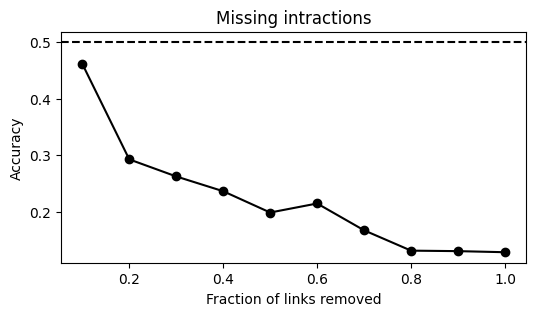

In [24]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')


### Spurious Intercations (Adding Links)

In [25]:
#add links to the adjacency matrix A_T based on a specified ratio
def link_adder(A_T, ratio):
    zero_index = np.where(A_T==0)
    zero_list = [[zero_index[0][i], zero_index[1][i]] for i in range(len(zero_index[0]))]
    r = random.sample(zero_list, int(ratio * np.sum(A_T)/2))
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
#This function is intended to extract the first elements from a list of pairs
def Extract(lst):
    return list(list(zip(*lst))[0])


In [26]:
def acc(k):
    zeros = k.count(0)
    ones = k.count(1)

    if zeros == 0:
        return 0  # Handle the case when there are no zeros (or return another appropriate value)

    ef = 0
    for i in range(len(k)):
        if k[i] == 1:
            ef += k[i:].count(0) / zeros

    return ef / ones

In [27]:
one_real = []
one_index = np.where(A_T==1)#find the indices of one entries in the adjacency matrix

for i in tqdm(range(len(one_index[0]))):
    #computed reliability for each link is appended to the one_real list
    one_real.append(R(one_index[0][i], one_index[1][i], A_T, es))

100%|██████████| 43/43 [00:00<00:00, 45.76it/s]


In [28]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('AT.npy')
    selected_links = link_adder(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 1
    np.save('A0',A_T)
    one_fake=[]
    for i in selected_links:
        one_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(one_fake),2))
    all_real = []
    for i in one_fake: all_real.append([0, i])
    for i in one_real: all_real.append([1, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 0.65
the mean value 0.66
the mean value 0.64
the mean value 0.65
the mean value 0.66
the mean value 0.67
the mean value 0.67
the mean value 0.67
the mean value 0.68
the mean value 0.68


##### conclusion:
the mean values of the reliabilities for added links as we systematically increased the link addition ratio. This information helps us to understand how network reliability changes as we add more links.it appears that as we add more links to the network, the mean reliability of the added links increases. This suggests that adding more links enhances network reliability. The increasing trend in mean reliability indicates that adding more links has a positive impact on the network's reliability.

Text(0.5, 1.0, 'ُSpurious intractions')

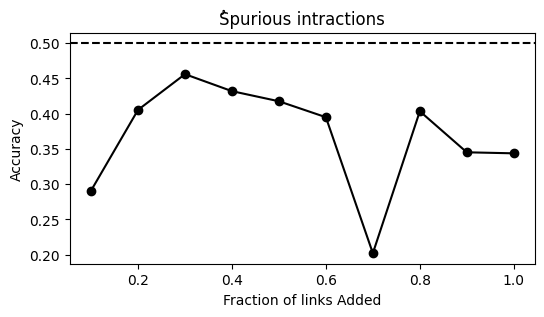

In [29]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links Added')
plt.title('ُSpurious intractions')

In [30]:
A_O = np.load('A0.npy')
A_T = np.load('AT.npy')

In [31]:
num_zeros_A_T = (A_T == 0).sum()
print('number of zero in true network',num_zeros_A_T)
num_one_A_T = (A_T == 1).sum()
print('number of one in true network',num_one_A_T)

number of zero in true network 1221
number of one in true network 1279


In [32]:
num_zeros_A_O = (A_O == 0).sum()
print('number of zero in A_O network',num_zeros_A_O)
num_one_A_O = (A_O == 1).sum()
print('number of one in A_O network',num_one_A_O)

number of zero in A_O network 582
number of one in A_O network 1918


In [33]:
# create empty matrix of shape A_O
shape_o=np.shape(A_O)
R_matix=np.zeros(shape_o)
es = Metropolis(100, 20,A_O)

 10%|█         | 2/20 [00:00<00:03,  4.98it/s]

796.6975073277406
99
793.6787670936938
99


 20%|██        | 4/20 [00:00<00:02,  6.10it/s]

798.8778284379382
99
772.0059979205247
99


 30%|███       | 6/20 [00:01<00:02,  6.15it/s]

798.2822875232551
99
803.693500147378
99


 40%|████      | 8/20 [00:01<00:01,  6.32it/s]

783.9559613512616
99
803.7579105389378
99


 50%|█████     | 10/20 [00:01<00:01,  6.24it/s]

772.734465144095
99
778.5796079400357
99


 60%|██████    | 12/20 [00:01<00:01,  6.23it/s]

806.5082401638911
99
811.8912242971853
99


 70%|███████   | 14/20 [00:02<00:00,  6.44it/s]

785.7519059464883
99
781.0188277427488
99


 80%|████████  | 16/20 [00:02<00:00,  6.38it/s]

793.9724799797266
99
787.307969973109
99


 90%|█████████ | 18/20 [00:02<00:00,  6.40it/s]

778.4135533849894
99
798.6079440050006
99


100%|██████████| 20/20 [00:03<00:00,  6.14it/s]

793.4866794301726
99
787.2575360998055
99


In [34]:
for i in range(shape_o[0]):
    for j in range(shape_o[1]):
        R_matix[i][j]= R(i,j, A_O, es)

In [35]:
print(np.max(R_matix))
print(np.min(R_matix))
R_matix

0.90909
0.16667


array([[0.90909, 0.81818, 0.875  , ..., 0.875  , 0.625  , 0.875  ],
       [0.63636, 0.63636, 0.875  , ..., 0.75   , 0.75   , 0.75   ],
       [0.5    , 0.75   , 0.83333, ..., 0.83333, 0.83333, 0.66667],
       ...,
       [0.625  , 0.625  , 0.5    , ..., 0.33333, 0.66667, 0.33333],
       [0.625  , 0.875  , 0.66667, ..., 0.66667, 0.66667, 0.33333],
       [0.625  , 0.625  , 0.83333, ..., 0.83333, 0.66667, 0.83333]])

In [36]:
A_O[np.where(R_matix > 0.5)] = 1
A_O[np.where(R_matix < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_O')

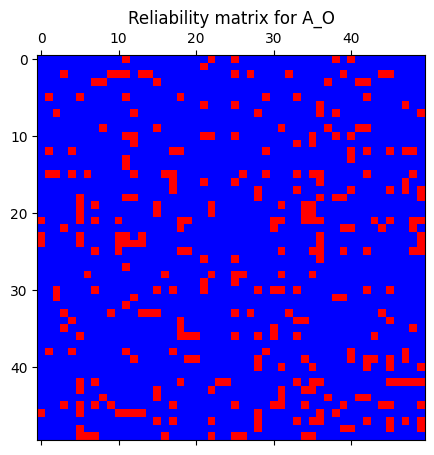

In [51]:
from matplotlib.colors import ListedColormap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_O, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_O')

In [38]:
shape_T=np.shape(A_T)
R_mat_A_T=np.zeros(shape_T)
es = Metropolis(100, 20,A_O)

 10%|█         | 2/20 [00:00<00:03,  5.10it/s]

640.8871579219305
99
629.654278915325
99


 20%|██        | 4/20 [00:00<00:02,  6.21it/s]

616.9192483088154
99
604.1220285607958
99


 30%|███       | 6/20 [00:00<00:02,  6.41it/s]

619.7316192224224
99
660.6702897379846
99


 40%|████      | 8/20 [00:01<00:01,  6.55it/s]

585.0648408034632
99
605.0254552841678
99


 50%|█████     | 10/20 [00:01<00:01,  6.46it/s]

632.8630892193898
99
656.1067352370725
99


 60%|██████    | 12/20 [00:01<00:01,  6.68it/s]

646.7717484965095
99
626.9398833117806
99


 70%|███████   | 14/20 [00:02<00:00,  6.90it/s]

612.8088131336025
99
616.6046445074883
99


 80%|████████  | 16/20 [00:02<00:00,  6.88it/s]

619.7677998505475
99
612.4924877442144
99


 90%|█████████ | 18/20 [00:02<00:00,  6.85it/s]

630.9515257988563
99
597.2542375071907
99


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]

637.7044935997714
99
637.9667642622759
99


In [39]:
for i in range(shape_T[0]):
    for j in range(shape_T[1]):
        R_mat_A_T[i][j]= R(i,j, A_T, es)

In [40]:
print(np.max(R_mat_A_T))
print(np.min(R_mat_A_T))
R_mat_A_T

0.83333
0.14286


array([[0.61111, 0.66667, 0.7    , ..., 0.66667, 0.27778, 0.5    ],
       [0.33333, 0.44444, 0.7    , ..., 0.5    , 0.66667, 0.83333],
       [0.6    , 0.5    , 0.16667, ..., 0.75   , 0.3    , 0.75   ],
       ...,
       [0.33333, 0.83333, 0.5    , ..., 0.33333, 0.5    , 0.66667],
       [0.44444, 0.55556, 0.7    , ..., 0.5    , 0.44444, 0.33333],
       [0.33333, 0.66667, 0.75   , ..., 0.33333, 0.16667, 0.66667]])

In [41]:
A_T[np.where(R_mat_A_T > 0.5)] = 1
A_T[np.where(R_mat_A_T < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_T')

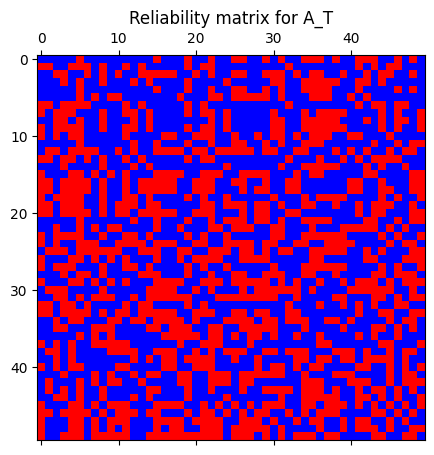

In [50]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_T, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_T')
